# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator

## Load monthly paths

In [2]:
import importlib
importlib.reload(market_generator)

<module 'market_generator' from '../src\\market_generator.py'>

In [3]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="W", sig_order=None)

## Plot paths

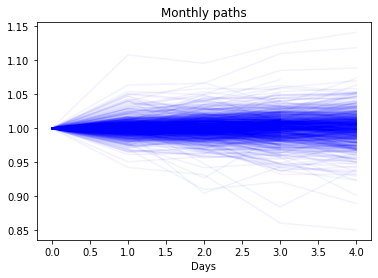

In [4]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Training: 100%|██████████| 10000/10000 [00:27<00:00, 360.78it/s]


## Generate

In [6]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))

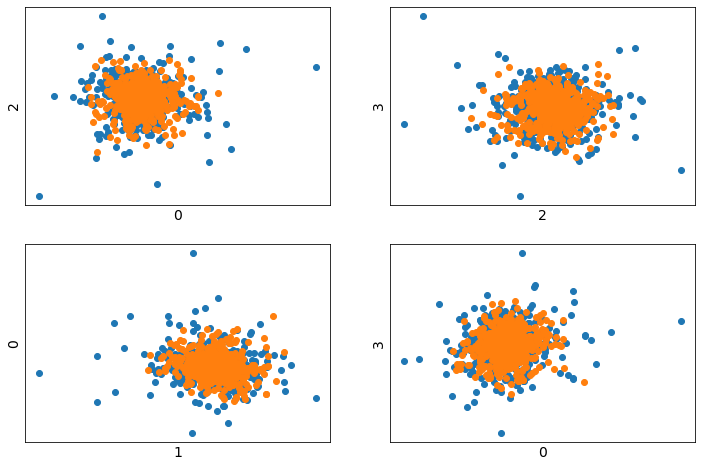

In [7]:
PROJECTIONS = [(0, 2), (2, 3), (1, 0), (0, 3)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(MG.orig_logsig[:, projection[0]], MG.orig_logsig[:, projection[1]],
                label="Real data")
    plt.scatter(generated[:, projection[0]], generated[:, projection[1]],
               label="Generated")
    plt.xlabel(projection[0], fontsize=14)
    plt.ylabel(projection[1], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

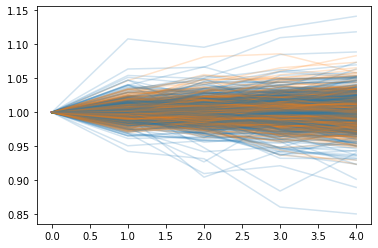

In [8]:
paths_generated = np.exp(MG.orig_logsig.cumsum(axis=1))
paths_orig = np.exp(generated.cumsum(axis=1))
for p1, p2 in zip(paths_generated, paths_orig):
    plt.plot(np.r_[1., p1], "C0", alpha=0.2)
    plt.plot(np.r_[1., p2], "C1", alpha=0.2)
    
    
plt.show()

In [10]:
from utils.leadlag import leadlag
import process_discriminator
import iisignature

order = 4
sigs1 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_generated[:-1])])
sigs2 = np.array([np.r_[1., iisignature.sig(leadlag(p), order)] for p in tqdm(paths_orig)])

100%|██████████| 818/818 [00:00<00:00, 13019.21it/s]


In [11]:
import importlib
importlib.reload(process_discriminator)

<module 'process_discriminator' from '../src\\process_discriminator.py'>

In [12]:
res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.9999)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

Computing signatures of population 2: 100%|██████████| 818/818 [00:00<00:00, 1337.99it/s]
Are the generated and real distributions DIFFERENT? False
